# Imports

In [153]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import torch
%matplotlib inline

# CNN Implementation

In [154]:
# Read in all words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [155]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

print (itos)
print (vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [156]:
random.seed(42)
random.shuffle(words)

In [157]:
# Build the dataset
block_size = 8 # Context length stores how man characters are taken to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr    = build_dataset(words[:n1])     # 80%
Xdev, Ydev  = build_dataset(words[n1:n2])   # 10%
Xte, Yte    = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [158]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x)), '-->', itos[y.item()]

........
.......y
......yu
.....yuh
....yuhe
...yuhen
..yuheng
........
.......d
......di
.....dio
....dion
...diond
..diondr
.diondre
........
.......x
......xa
.....xav
....xavi


In [159]:
# Training a deeper NN

#-------------------------------------------------------------------------------

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Note: Kaiming init
        self.bias   = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#-------------------------------------------------------------------------------

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Parameters (Trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers (Trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        # Calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)                 # Batch mean
            xvar = x.var(dim, keepdim=True)                   # Batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)    # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # Update the buffers using exponential moving average
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

#-------------------------------------------------------------------------------

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
#-------------------------------------------------------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

#-------------------------------------------------------------------------------

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
#-------------------------------------------------------------------------------

class Sequential:
    def __init__(self,layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # Get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [160]:
torch.manual_seed(42)

In [161]:
# MLP Revisited
n_embd = 24     # The dimensionality of the character embedding vectors
n_hidden = 128  # The number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Last layer makes less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))    # Number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [162]:
# Optimizations
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]              # Batch X, Y

    # Forward Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)        # Loss function

    # Backward Pass
    for layer in model.layers:
        layer.out.retain_grad() # Would take out retain_grad after debug
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update: Simple SGD
    lr = 0.1 if i < 150000 else 0.01   # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:                      # Print every once in a while
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    # if i > 1000: # Comment in and out to run full loop or just once
    #     break

      0 / 200000: 3.3167
  10000 / 200000: 2.0576
  20000 / 200000: 2.0723
  30000 / 200000: 2.5134
  40000 / 200000: 2.1476
  50000 / 200000: 1.7836
  60000 / 200000: 2.2592
  70000 / 200000: 1.9331
  80000 / 200000: 1.6875
  90000 / 200000: 2.0395
 100000 / 200000: 1.7736
 110000 / 200000: 1.9570
 120000 / 200000: 1.7465
 130000 / 200000: 1.8126
 140000 / 200000: 1.7405
 150000 / 200000: 1.7466
 160000 / 200000: 1.8806
 170000 / 200000: 1.6266
 180000 / 200000: 1.6476
 190000 / 200000: 1.8555


# Visualizations

<Figure size 2000x400 with 0 Axes>

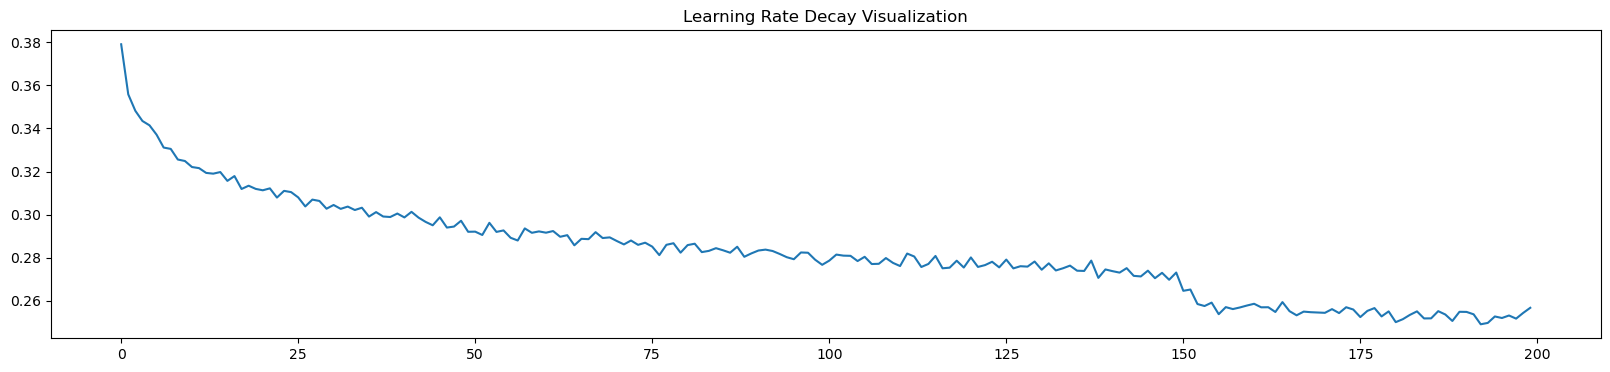

In [163]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.title("Learning Rate Decay Visualization")
plt.show()

In [164]:
# Put layers into eval mode (Especially needed for BatchNorm)
for layer in model.layers:
    layer.training = False

layer 4 (      Tanh): mean +0.00, std 0.61, saturated: 16.36%
layer 8 (      Tanh): mean +0.01, std 0.72, saturated: 24.40%
layer 12 (      Tanh): mean -0.02, std 0.71, saturated: 15.50%


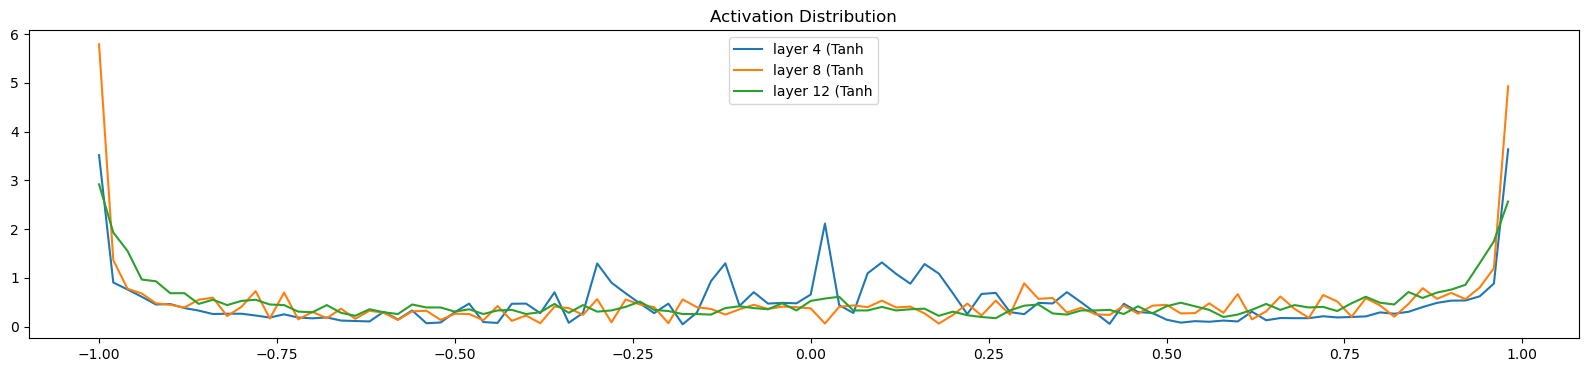

In [165]:
# Visualize histograms
plt.figure(figsize=(20, 4))             # Width and height of the plot
legends = []

for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Activation Distribution')
plt.show()

layer 4 (      Tanh): mean -0.000000, std 2.869604e-03
layer 8 (      Tanh): mean +0.000000, std 3.340409e-03
layer 12 (      Tanh): mean +0.000043, std 6.303410e-03


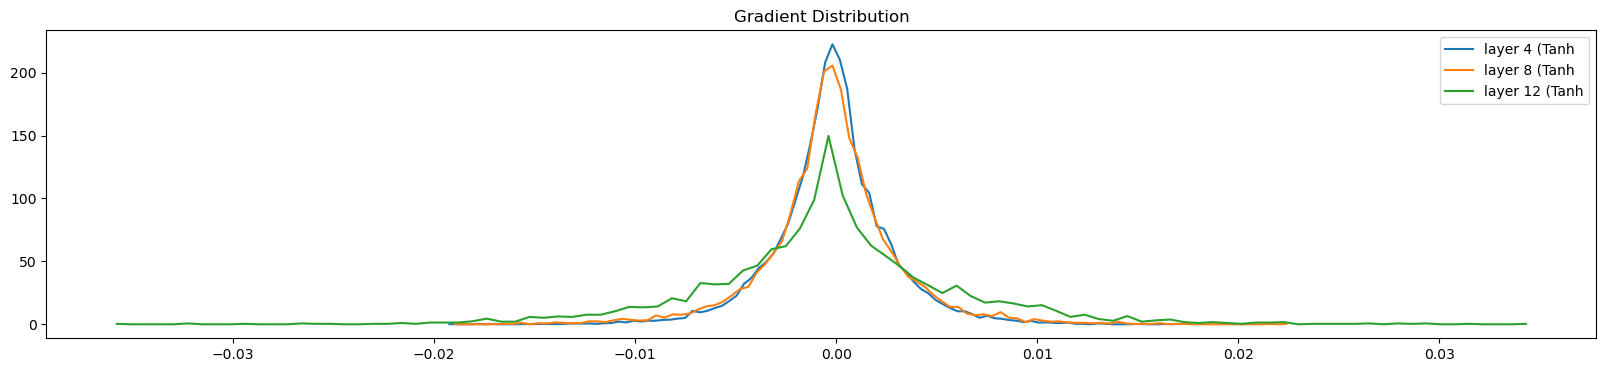

In [166]:
# Visualize histograms
plt.figure(figsize=(20, 4))             # Width and height of the plot
legends = []

for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Gradient Distribution')
plt.show()

weight   (27, 24) | mean +0.000000 | std 1.221442e-02 | grad:data ratio 1.130352e-02
weight  (48, 128) | mean -0.000007 | std 7.512081e-03 | grad:data ratio 2.134080e-02
weight (256, 128) | mean -0.000014 | std 4.999253e-03 | grad:data ratio 2.317387e-02
weight (256, 128) | mean +0.000031 | std 4.720370e-03 | grad:data ratio 2.401658e-02
weight  (128, 27) | mean -0.000000 | std 1.962640e-02 | grad:data ratio 7.822821e-02


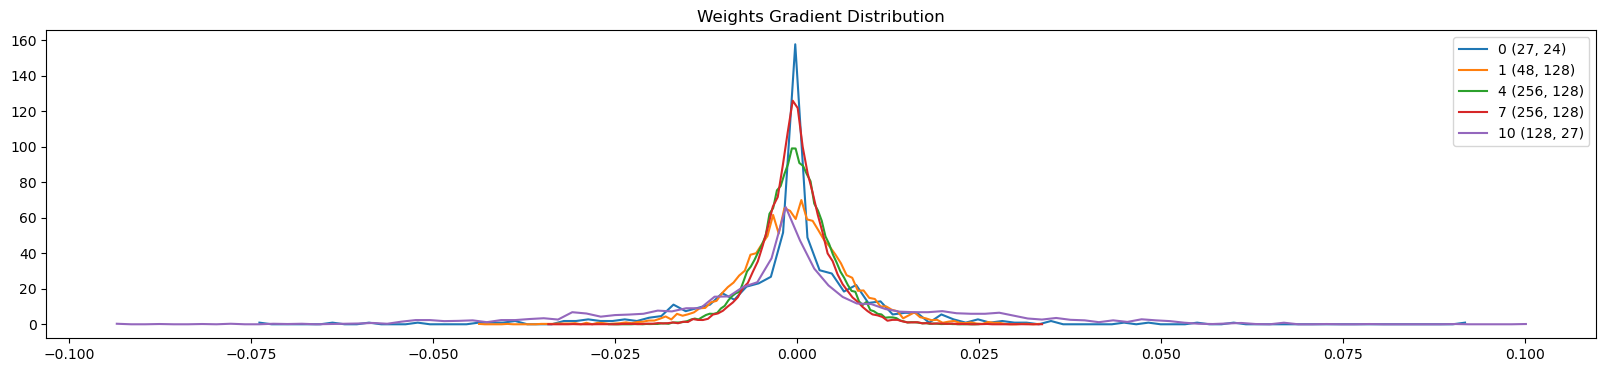

In [167]:
# Visualize histograms
plt.figure(figsize=(20, 4))             # Width and height of the plot
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient Distribution')
plt.show()

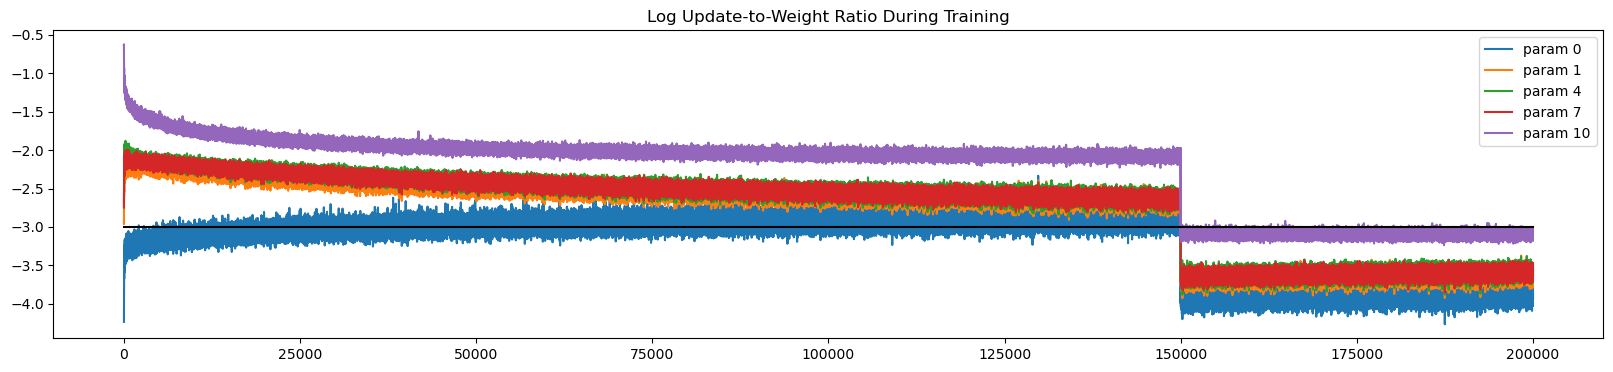

In [172]:
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range (len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Log Update-to-Weight Ratio During Training')
plt.show()

# Sampling from Model

In [169]:
# Evaluate loss
@torch.no_grad()    # Disables gradient tracking
def split_loss(split):
    x, y = {
        'train':    (Xtr, Ytr),
        'val':      (Xdev, Ydev),
        'test':     (Xte, Yte),
    } [split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690280675888062
val 1.9936515092849731


In [173]:
# Sample from model

for _ in range(20):
    out = []
    context = [0] * block_size  # Initializes with all ...

    while True:
        # Forward passt to nn
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # Sample from the distribution
        ix  = torch.multinomial(probs, num_samples=1).item()

        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # If we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))    # Decode and print the generated word

elyza.
reyden.
renna.
zaya.
emina.
aleken.
alphonze.
davide.
tlaurne.
korie.
akshan.
amalice.
delika.
abrirann.
islak.
mahad.
isogam.
teigoste.
suvion.
lairaz.
